In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qutip as qt

import sim_utils as su

MHz = 1.0 # work in units of MHz
pi = np.pi

In [47]:
### system parameters
K = 2. * pi * 6. * MHz # Kerr nonlinearity
e_2 = 2. * pi * 15.5 * MHz # two-photon drive strength
n_th = 0.0 # population of n=1 Fock state due to thermal noise
g_12 = 2. * pi * 150.0e-3 * MHz

### drive parameters
tau = 320.0e-3 / MHz # drive ramp time, ns

### simulation parameters
N = 10 # dimensionality of the Hilbert space, per resonator
tmax = 2. / MHz # go for 1 μs
dt = 1.0e-3 / MHz

### get the encoded basis states
psi_0, psi_1 = su.cat_states(K, e_2, N)

### define the Hamiltonian, now with coupling!
H = [su.H_kerr(K, N, nres=2, res_index=0),
     su.H_kerr(K, N, nres=2, res_index=1),
     su.H_2ph(e_2, N, tau=tau, t0=0., nres=2, res_index=0),
     su.H_2ph(e_2, N, tau=tau, t0=0., nres=2, res_index=1),
     su.H_c(g_12, N, tau=0.01*tau, t0=0.5/MHz)
    ]

In [48]:
t = np.arange(0., tmax, dt)

### initialize to the ground state
psi_init = (1. - n_th) * qt.basis(N, 0) + n_th * qt.basis(N, 1)
#psi_init = psi_0
rho_init = qt.tensor([psi_init * psi_init.dag()] * 2)

basis = su.basis(K, e_2, N)

result = qt.mesolve(H, rho_init, t, 
                    #e_ops=[qt.tensor(psi_0 * psi_0.dag(), qt.identity(N)), qt.tensor(psi_0 * psi_0.dag(), qt.identity(N))],
                    e_ops=[psi * psi.dag() for psi in basis],
                    options=qt.Options(store_states=False, store_final_state=True))#, nsteps=25000))

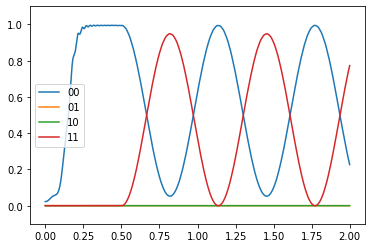

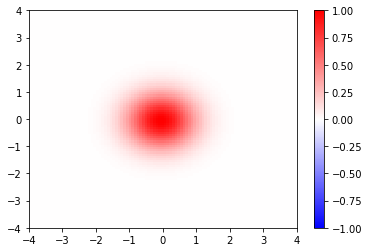

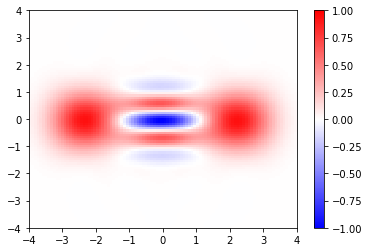

In [49]:
plt.figure()
plt.plot(t * MHz, result.expect[0], label="00")
plt.plot(t * MHz, result.expect[1], label="01")
plt.plot(t * MHz, result.expect[2], label="10")
plt.plot(t * MHz, result.expect[3], label="11")
plt.legend()
plt.ylim(-0.1, 1.1)
x = np.linspace(-4., 4., 100)
plt.figure()
w = qt.wigner(rho_init.ptrace(0), x[1:], x[1:])
w /= np.max(np.abs(w))
fig = plt.pcolormesh(x, x, w, cmap="bwr", vmin=-1., vmax=1.)
plt.colorbar(fig)
plt.figure()
w = qt.wigner(result.final_state.ptrace(0), x[1:], x[1:])
w /= np.max(np.abs(w))
fig = plt.pcolormesh(x, x, w, cmap="bwr", vmin=-1., vmax=1.)
plt.colorbar(fig)